## Using recurrent neural network

In [1]:
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.layers import Dense, Embedding, LSTM
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [2]:
gpu_devices = tf.config.experimental.list_physical_devices("GPU")
for device in gpu_devices:
    tf.config.experimental.set_memory_growth(device, True)

In [3]:
df = pd.read_csv('IMDB_Dataset.csv')

In [4]:
df = df.sample(10000)

In [5]:
df.isnull().values.any()

False

In [6]:
df.shape

(10000, 2)

In [7]:
df.head()

,review,sentiment
49638,This has to be one of the biggest misfires eve...,negative
22715,I would ward off any temptation to view this m...,negative
19159,I grew up in Houston and was nine when this mo...,positive
36725,I saw this film at a time when I was timidly t...,positive
33349,"I don't want to go off on a rant here, but.......",negative


In [8]:
TAG_RE = re.compile(r'<[^>]+>')

def remove_tags(text):
    return TAG_RE.sub('', text)

In [9]:

def preprocess_text(sen):
    # Removing html tags
    sentence = remove_tags(sen)

    # Remove punctuations and numbers
    sentence = re.sub('[^a-zA-Z]', ' ', sentence)

    # Single character removal
    sentence = re.sub(r"\s+[a-zA-Z]\s+", ' ', sentence)

    # Removing multiple spaces
    sentence = re.sub(r'\s+', ' ', sentence)

    return sentence

In [10]:
X = []
sentences = list(df['review'])
for sen in sentences:
    X.append(preprocess_text(sen))

In [11]:
X[3]

'I saw this film at time when was timidly toying with the idea of moving into my own apartment and starting life on my own Maybe that is the reason why took it so seriously believed totally in the poor character psychological degradation inside Paris of perpetual construction sites dust squalor selfishness rudeness malice and decay m giving all the credit to Polanski artistry in his direction his playing and his inescapable script but fainted during the horrible final scene and had to be revived by cognac in the office of the theatre manager Luckily for me my life on my own didn turn out as disastrous as this so far but have always kept great respect for an artist who can perform such illusions and so totally immerse himself in the fake reality he is trying to convey Simply put the man is genius of the first order and credit to the human race This film is the sum of many many instances of great acting and great casting As some performances were done in English the scenes with Shelley W

In [12]:
y = df['sentiment']
y = np.array(list(map(lambda x: 1 if x=="positive" else 0, y)))

In [13]:
# Spliting data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [14]:
# Tokenizing
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(X_train)

X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

In [15]:
# Adding 1 because of reserved 0 index
vocab_size = len(tokenizer.word_index) + 1

maxlen = 256

X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

In [16]:
# Open glove file which is an unsupervised algorithm for obtaining  vector representations for words.

embeddings_dictionary = dict()
glove_file = open('glove/glove.6B.200d.txt',encoding="utf8") # download link: https://www.kaggle.com/incorpes/glove6b200d/download

for line in glove_file:
    records = line.split()
    word = records[0]
    vector_dimensions = np.asarray(records[1:], dtype='float32')
    embeddings_dictionary [word] = vector_dimensions
glove_file.close()

In [17]:
embedding_matrix = np.zeros((vocab_size, 200))
for word, index in tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

In [18]:
model = Sequential()
embedding_layer = Embedding(vocab_size, 200, weights=[embedding_matrix], input_length=maxlen , trainable=False)
model.add(embedding_layer)
model.add(LSTM(128,return_sequences=True))
model.add(LSTM(32))

model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

In [19]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 256, 200)          9490600   
_________________________________________________________________
lstm (LSTM)                  (None, 256, 128)          168448    
_________________________________________________________________
lstm_1 (LSTM)                (None, 32)                20608     
_________________________________________________________________
dense (Dense)                (None, 1)                 33        
Total params: 9,679,689
Trainable params: 189,089
Non-trainable params: 9,490,600
_________________________________________________________________


In [20]:
history = model.fit(X_train, y_train, batch_size=128, epochs=16, verbose=1, validation_split=0.2)

score = model.evaluate(X_test, y_test, verbose=1)

Epoch 1/16
50/50 [==============================] - 9s 98ms/step - loss: 0.6883 - acc: 0.5344 - val_loss: 0.6638 - val_acc: 0.5644
Epoch 2/16
50/50 [==============================] - 3s 53ms/step - loss: 0.6598 - acc: 0.5980 - val_loss: 0.6931 - val_acc: 0.5044
Epoch 3/16
50/50 [==============================] - 3s 52ms/step - loss: 0.6942 - acc: 0.4969 - val_loss: 0.6924 - val_acc: 0.5150
Epoch 4/16
50/50 [==============================] - 3s 52ms/step - loss: 0.6906 - acc: 0.5215 - val_loss: 0.6893 - val_acc: 0.5138
Epoch 5/16
50/50 [==============================] - 3s 52ms/step - loss: 0.6845 - acc: 0.5379 - val_loss: 0.6825 - val_acc: 0.5594
Epoch 6/16
50/50 [==============================] - 3s 52ms/step - loss: 0.6793 - acc: 0.5531 - val_loss: 0.6191 - val_acc: 0.6744
Epoch 7/16
50/50 [==============================] - 3s 52ms/step - loss: 0.6420 - acc: 0.6416 - val_loss: 0.7628 - val_acc: 0.5475
Epoch 8/16
50/50 [==============================] - 3s 53ms/step - loss: 0.6353 - a

In [21]:
print("Test Score:", score[0])
print("Test Accuracy:", score[1])

Test Score: 0.3367294371128082
Test Accuracy: 0.8615000247955322


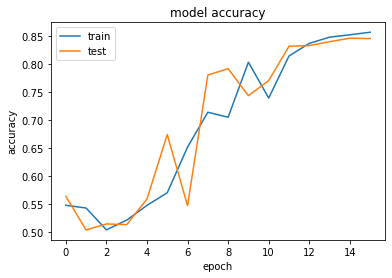

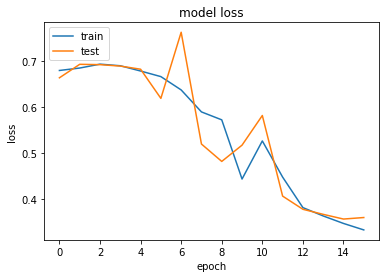

In [22]:
import matplotlib.pyplot as plt

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

In [23]:
model.save('model-glove-rnn.h5')